In [1]:
from fastai.vision.all import *
from fastcore.parallel import *
import timm

In [2]:
path = Path.home()/'.fastai/data/paddy'; path

Path('/home/bilal/.fastai/data/paddy')

In [3]:
trn_path = path/'train_images'

In [4]:
files = get_image_files(trn_path); files

(#10407) [Path('/home/bilal/.fastai/data/paddy/train_images/hispa/103939.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/106442.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/105708.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/100789.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/107842.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/101076.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/109689.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/101515.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/109965.jpg'),Path('/home/bilal/.fastai/data/paddy/train_images/hispa/102479.jpg')...]

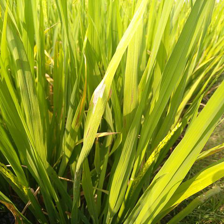

In [5]:
PILImage.create(files[0]).resize((224,224))

In [6]:
def f(o): return PILImage.create(o).size

In [7]:
# %time sizes = parallel(f, files, n_workers=8)
# pd.DataFrame(list(sizes)).value_counts()

In [8]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, bs=32, 
                                   item_tfms=Resize(224, method='squish'))

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


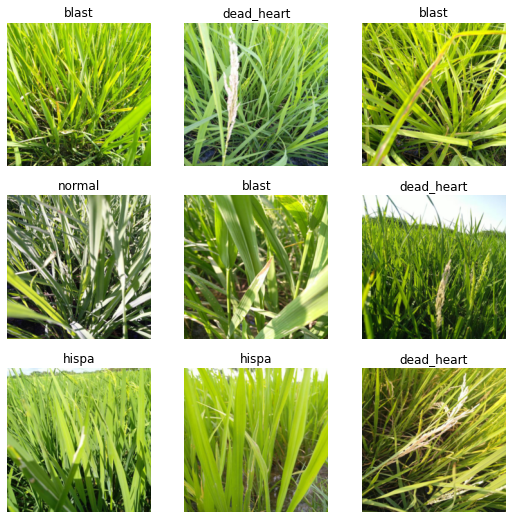

In [9]:
dls.show_batch()

In [ ]:
def show_batch(self, b=None, max_n=9, ctxs=None, show=True, unique=False, **kwargs):
        if unique:
            old_get_idxs = self.get_idxs
            print(old_get_idxs)
            self.get_idxs = lambda: Inf.zeros
        if b is None: b = self.one_batch()
        if not show: return self._pre_show_batch(b, max_n=max_n)
        show_batch(*self._pre_show_batch(b, max_n=max_n), ctxs=ctxs, max_n=max_n, **kwargs)
        if unique: self.get_idxs = old_get_idxs
        
dls.show_batch=show_batch

In [ ]:
Inf.zeros??

In [ ]:
dls.show_batch(max_n=9)

In [ ]:
class CustomComboLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=0.75):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)       
    def __call__(self, pred, targ):
        return (self.alpha * self.focal_loss(pred, targ)) + ((1-self.alpha) * self.dice_loss(pred, targ))
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)



In [ ]:
timm.list_models('*convnext*')

In [ ]:
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate).to_fp16()

In [ ]:
learn.fine_tune(5)

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
test_files = get_image_files(path/'test_images').sorted(); test_files

In [ ]:
test_dl=dls.test_dl(test_files)

In [ ]:
test_dl.show_batch()

In [ ]:
probs, _, idxs=learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
idxs = pd.Series(idxs.numpy(),name="idxs")

In [ ]:
sample_submit = pd.read_csv(path/'sample_submission.csv')

In [ ]:
sample_submit.head()

In [ ]:
mapping = {k:v for k,v in enumerate(dls.vocab)};mapping

In [ ]:
result=idxs.map(mapping); result

In [ ]:
sample_submit['label'] = result
sample_submit.head()

In [ ]:
sample_submit.to_csv('my_submit_convnext_large_in22k.csv', index=False)

In [ ]:
!kaggle competitions submit -f ~/mlworks/plant_disease_detection/sample_submit_convnext_large_in22k.csv -m 'convnext_large_in22k 5 epochs' paddy-disease-classification